In [1]:
import numpy as np
from sklearn.neighbors import KDTree
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import os
from tqdm import tqdm

### Here to do:

- load daily events
- filter to selected 30 minutes interval
- (match source and destination coordinates to coordinates of towers) - already done
- encode mobility graph as edgelist
- add node and edge properties
- save to disk

### Locate files

In [2]:
source = '/mnt/DayEventData/'
target = '/mnt/TimeIntervalGraphs/'

In [3]:
files = np.array( sorted([ i for i in os.listdir(source) ]) )
files.shape, files[:3]

((365,),
 array(['output_daily-events-data_20181201.npy',
        'output_daily-events-data_20181202.npy',
        'output_daily-events-data_20181203.npy'], dtype='<U37'))

In [4]:
eq_info = np.load( source+files[0] )
eq_info.shape, eq_info[:5]

((14159238, 11),
 array([[     0,   1030, 345487, 881163, 345310, 880801,      5,      0,
              4,   1757,  21204],
        [     1,    363, 156564, 770772, 149221, 760274,     10,     12,
             76,  13707,  13712],
        [     1,    536, 148846, 757811, 146361, 760609,      2,      3,
            112,  31731,   3480],
        [     1,    538, 146361, 760609, 139448, 759589,      5,      6,
             83,   3480,  31569],
        [     1,    543, 139448, 759589, 149221, 760274,     30,      9,
             19,  31569,  13709]], dtype=int32))

In [5]:
tower_info = pd.read_csv( '/mnt/DayPolygonData/fixed_tower_locations.csv' ).values[:,:4]
tower_info.shape, tower_info[:5]

((43376, 4),
 array([[ 71892,      0, 250859, 557285],
        [ 72307,      1, 243343, 558377],
        [ 72922,      2, 247254, 549716],
        [ 73325,      3, 248646, 551068],
        [140903,      4, 273540, 796042]]))

In [6]:
np.max( tower_info[:,1] ), np.min( tower_info[:,1] )

(43383, 0)

#### Define adjmat

In [7]:
adj_mat = np.zeros( (43384, 43384), dtype=np.uint32 )
adj_mat.shape

(43384, 43384)

In [8]:
adj_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

#### Check if towers are really matched

In [9]:
eq_info[0]

array([     0,   1030, 345487, 881163, 345310, 880801,      5,      0,
            4,   1757,  21204], dtype=int32)

In [10]:
tower_info[ tower_info[:,1] == 1757 ], tower_info[ tower_info[:,1] == 21204 ] 

(array([[1599873,    1757,  345487,  881163]]),
 array([[146902721,     21204,    345310,    880801]]))

### Specify a 30 minutes interval

In [11]:
eq_interval = eq_info[ np.in1d( eq_info[:,1], np.arange(600, 630) ) ]
eq_interval.shape, eq_interval[:3]

((543778, 11),
 array([[     6,    612, 304522, 776222, 305704, 777890,      1,      2,
            122,  15070,  39568],
        [     6,    613, 305704, 777890, 305349, 777562,      2,      0,
             14,  39568,   5073],
        [     6,    615, 304522, 776222, 305349, 777562,      1,      1,
             94,  15070,   5073]], dtype=int32))

In [12]:
uq, counts = np.unique( np.concatenate( ( eq_interval[:,-2:], 
                             np.ones(eq_interval.shape[0]).reshape(-1,1) ), 
                          axis=1 ).astype(np.uint16), 
          return_counts=True, axis=0 )
V = np.concatenate( ( uq[:,:2], counts.reshape(-1,1) ), axis=1 )

In [28]:
V[ np.argsort( V[:,0] ) ][:40]

array([[    0,     2,     2],
       [    0, 42861,     1],
       [    0, 32153,    16],
       [    0, 31997,     1],
       [    0, 31878,     1],
       [    0, 31482,     1],
       [    0, 26496,     2],
       [    0, 26227,     1],
       [    0, 26221,     1],
       [    0, 23758,     2],
       [    0, 20375,     1],
       [    0, 24465,     1],
       [    0, 15296,     1],
       [    0, 14988,     1],
       [    0, 12378,     4],
       [    0, 12375,    15],
       [    0,  9109,     1],
       [    0,  8669,     1],
       [    0,  7441,     8],
       [    0,  7412,     9],
       [    0,  4304,     1],
       [    0, 15297,     1],
       [    1, 20584,     1],
       [    1, 40927,     1],
       [    1, 31999,     3],
       [    1, 31997,     1],
       [    1, 26496,     3],
       [    1, 20491,     1],
       [    1, 41868,     1],
       [    1, 12376,     1],
       [    1, 12375,     1],
       [    1,  8670,     1],
       [    1,  8669,     5],
       [  

In [14]:
adj_mat[ V[:,0], V[:,1] ] = V[:,2]

In [15]:
adj_mat = adj_mat + adj_mat.T

In [16]:
adj_mat

array([[0, 1, 4, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [17]:
idxs = np.argwhere( adj_mat )

In [18]:
filt = idxs[:,0] < idxs[:,1]

In [19]:
V_new = np.concatenate( (idxs[filt], adj_mat[ idxs[:,0][filt], idxs[:,1][filt] ].reshape(-1,1) ), axis=1 )

In [20]:
V_new

array([[    0,     1,     1],
       [    0,     2,     4],
       [    0,  4304,     1],
       ...,
       [43378, 43380,     2],
       [43378, 43383,     2],
       [43379, 43380,     3]])

#### Data structure to save data as

- `data.x`: Node feature matrix with shape [num_nodes, num_node_features]

- `data.edge_index`: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- `data.edge_attr`: Edge feature matrix with shape [num_edges, num_edge_features]

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

- `data.pos`: Node position matrix with shape [num_nodes, num_dimensions]

In [39]:
data_edge_index = V_new[:,:2].T
data_edge_attr = V_new[:,-1].reshape(-1,1)
data_x = tower_info[:,2:]
data_edge_index.shape, data_edge_attr.shape, data_x.shape

((2, 232656), (232656, 1), (43376, 2))

### Define functions to do the work for all files and time intervals

In [11]:
time_splits = np.vstack( (np.arange(0,1470,30)[:-1], np.arange(0,1470,30)[1:]) ).T
time_splits[:3], time_splits[-3:]

(array([[ 0, 30],
        [30, 60],
        [60, 90]]),
 array([[1350, 1380],
        [1380, 1410],
        [1410, 1440]]))

In [12]:
def create_graph( eq_interval, tower_info, savename ):
    # get multiple movements as weights
    uq, counts = np.unique( np.concatenate( ( eq_interval[:,-2:], 
                                 np.ones(eq_interval.shape[0]).reshape(-1,1) ), 
                              axis=1 ).astype(np.uint16), 
              return_counts=True, axis=0 )
    
    # create edgelist
    V = np.concatenate( ( uq[:,:2], counts.reshape(-1,1) ), axis=1 )
    
    # create adjacency matrix and make graph undirected
    adj_mat = np.zeros( (43384, 43384), dtype=np.uint32 )
    adj_mat[ V[:,0], V[:,1] ] = V[:,2]
    adj_mat = adj_mat + adj_mat.T
    
    # get back the edgelist
    idxs = np.argwhere( adj_mat )
    filt = idxs[:,0] < idxs[:,1]
    V_new = np.concatenate( (idxs[filt], adj_mat[ idxs[:,0][filt], idxs[:,1][filt] ].reshape(-1,1) ), axis=1 )
    
    data_edge_index = V_new[:,:2].T
    data_edge_attr = V_new[:,-1].reshape(-1,1)
    data_x = tower_info[:,2:]
    np.savez_compressed( savename, data_edge_index=data_edge_index, 
                         data_edge_attr=data_edge_attr, data_x=data_x )

In [13]:
current_day = files[0]
eq_info = np.load( source+current_day )
date = current_day.split('.npy')[0][-8:]
date

'20181201'

In [14]:
current_day = files[0]
eq_info = np.load( source+current_day )
date = current_day.split('.npy')[0][-8:]

for i in tqdm( range(time_splits.shape[0]) ):
    eq_interval = eq_info[ np.in1d( eq_info[:,1],
                                    np.arange( time_splits[i,0], time_splits[i,1] ) ) ]
    savename = target+'graph_'+date+'_'+str(i)+'_'+'minutes-'+str(time_splits[i,0])+'-'+str(time_splits[i,1])
    #print(savename)
    create_graph( eq_interval, tower_info, savename )

100%|██████████| 48/48 [00:50<00:00,  1.04s/it]


### Some investigations

In [37]:
eq_interval = eq_info[ np.in1d( eq_info[:,1], np.arange(600, 660) ) ]
print( eq_interval.shape )

uq, counts = np.unique( np.concatenate( ( eq_interval[:,-2:], 
                             np.ones(eq_interval.shape[0]).reshape(-1,1) ), 
                          axis=1 ).astype(np.uint16), 
          return_counts=True, axis=0 )
V = np.concatenate( ( uq[:,:2], counts.reshape(-1,1) ), axis=1 )

data_edge_index = V[:,:2].T
data_edge_attr = V[:,-1].reshape(-1,1)
data_x = tower_info[:,2:]
data_edge_index.shape, data_edge_attr.shape, data_x.shape

(1097878, 11)


((2, 476789), (476789, 1), (43376, 2))

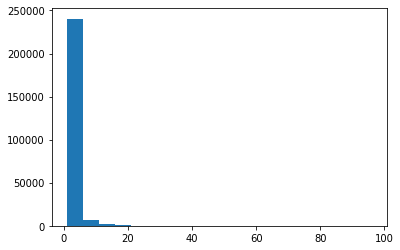

In [30]:
_ = plt.hist( data_edge_attr.flatten(), np.arange(1,100,5) )

In [31]:
(data_edge_attr.flatten() == 1).sum() / data_edge_attr.flatten().shape[0]

0.7464670922298041

In [32]:
(data_edge_attr.flatten() == 2).sum() / data_edge_attr.flatten().shape[0]

0.1260320573109479

In [33]:
(data_edge_attr.flatten() == 3).sum() / data_edge_attr.flatten().shape[0]

0.04989494326936546

In [34]:
(data_edge_attr.flatten() == 4).sum() / data_edge_attr.flatten().shape[0]

0.025333680187301144

In [35]:
(data_edge_attr.flatten() == 5).sum() / data_edge_attr.flatten().shape[0]

0.014551858003321793

#### Very small number of valid events are registered in this 30 minutes period!

In [111]:
0.7171292739147138+0.13450482959222876+0.05554374073870808+0.029430327643927338+0.01738721804511278

0.9539953899346908

### TODO:
- investigate polygon grid
- fix polygon grid somehow beyond days, towers should be at the same pos
- maybe do it in post proc phase with np.isclose and threshold
- check polygons for technology (2G, 3G, 4G), maybe embed data into multiple layers?


- check mobilecell data for different kind of events (data, sms, call)
- which is most problematic?


- can do great improvement:
    * match polygon grid with openstreetmap
    * movements should be along roads, trainlines, etc.
    * might be good to interpolate only events shorter that 60 minutes


- goal: 
    * same network node distribution, same positions, but different links
    * graph links evolving in time -> encoder embedding, LSTM or RNN to pred, then tranform back or look for link prediction algorithms

Some sources:

- https://github.com/facebookresearch/SEAL_OGB
- https://ogb.stanford.edu/docs/linkprop/#ogbl-ppa
- https://ogb.stanford.edu/docs/leader_linkprop/


https://towardsdatascience.com/tutorial-on-variational-graph-auto-encoders-da9333281129

https://github.com/tkipf/gae

https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html